# Dark current y hot pixeles

Cada imagen de un CCD contiene corriente oscura , que son recuentos en una imagen sin procesar causados ​​por efectos térmicos en el CCD. La corriente oscura en los CCD modernos es extremadamente pequeña si la cámara se enfría de alguna manera. Las cámaras enfriadas con nitrógeno líquido tienen una corriente oscura casi nula, mientras que los CCD enfriados termoeléctricamente tienen una corriente oscura algo mayor. La corriente oscura en un CCD que funciona a temperatura ambiente suele ser muy grande.

Incluso una cámara en la que la corriente oscura suele ser muy pequeña tendrá una pequeña fracción de píxeles, llamados píxeles calientes, en los que la corriente oscura es mucho mayor.

El siguiente cuaderno explica cómo identificar esos píxeles y cómo decidir la forma correcta de eliminar la corriente oscura de sus datos.

## 3.1. Corriente oscura: el caso ideal 

In [1]:
import numpy as np
from scipy import stats

%matplotlib inline
from matplotlib import pyplot as plt

from image_sim import dark_current, read_noise

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

<h2>3.1.1.1. Funciones de conveniencia

In [3]:
def generate_dark_frames(n_frames, 
                         dark_rate=0, 
                         noise=0,
                         gain=1,
                         exposure=10,
                         image_size=500):
    
    base_image = np.zeros([image_size, image_size])
    darks = np.zeros([n_frames, image_size, image_size])
    
    for n in range(n_images):
        darks[n] = dark_current(base_image, dark_rate, exposure, gain=gain, hot_pixels=False)
        if noise > 0:
            darks[n] = darks[n] + read_noise(base_image, noise, gain=gain)

    return darks

Generar dark frames

In [4]:
def plot_dark_with_distributions(image, rn, dark_rate, 
                                 n_images=1,
                                 exposure=1,
                                 gain=1,
                                 show_poisson=True, 
                                 show_gaussian=True):
    """
    Plot the distribution of dark pixel values, optionally overplotting the expected Poisson and
    normal distributions corresponding to dark current only or read noise only.
    
    Parameters
    ----------
    
    image : numpy array
        Dark frame to histogram.
    
    rn : float
        The read noise, in electrons.
        
    dark_rate : float
        The dark current in electrons/sec/pixel.
    
    n_images : float, optional
        If the image is formed from the average of some number of dark frames then 
        the resulting Poisson distribution depends on the number of images, as does the 
        expected standard deviation of the Gaussian.
        
    exposure : float
        Exposure time, in seconds.
        
    gain : float, optional
        Gain of the camera, in electron/ADU.
        
    show_poisson : bool, optional
        If ``True``, overplot a Poisson distribution with mean equal to the expected dark
        counts for the number of images.
    
    show_gaussian : bool, optional
        If ``True``, overplot a normal distribution with mean equal to the expected dark
        counts and standard deviation equal to the read noise, scaled as appropiate for 
        the number of images.
    """
    
    h = plt.hist(image.flatten(), bins=20, align='mid', 
                 density=True, label="Dark frame");

    bins = h[1]
    
    expected_mean_dark = dark_rate * exposure / gain
    
    pois = stats.poisson(expected_mean_dark * n_images)

    pois_x = np.arange(0, 300, 1)

    new_area = np.sum(1/n_images * pois.pmf(pois_x))

    if show_poisson:
        plt.plot(pois_x / n_images, pois.pmf(pois_x) / new_area, 
                 label="Poisson dsitribution, mean of {:5.2f} counts".format(expected_mean_dark)) 

    if show_gaussian:
        # The expected width of the Gaussian depends on the number of images.
        expected_scale = rn / gain * np.sqrt(n_images)
        
        # Mean value is same as for the Poisson distribution 
        expected_mean = expected_mean_dark * n_images
        gauss = stats.norm(loc=expected_mean, scale=expected_scale)
        
        gauss_x = np.linspace(expected_mean - 5 * expected_scale,
                              expected_mean + 5 * expected_scale,
                              num=100)
        plt.plot(gauss_x / n_images, gauss.pdf(gauss_x) * n_images, label='Gaussian, standard dev is read noise in counts') 
        
    plt.xlabel("Dark counts in {} sec exposure".format(exposure))
    plt.ylabel("Fraction of pixels (area normalized to 1)")
    plt.grid()
    plt.legend()

dark counts

In [5]:
def plot_dark_with_distributions(image, rn, dark_rate, 
                                 n_images=1,
                                 exposure=1,
                                 gain=1,
                                 show_poisson=True, 
                                 show_gaussian=True):
    """
    Plot the distribution of dark pixel values, optionally overplotting the expected Poisson and
    normal distributions corresponding to dark current only or read noise only.
    
    Parameters
    ----------
    
    image : numpy array
        Dark frame to histogram.
    
    rn : float
        The read noise, in electrons.
        
    dark_rate : float
        The dark current in electrons/sec/pixel.
    
    n_images : float, optional
        If the image is formed from the average of some number of dark frames then 
        the resulting Poisson distribution depends on the number of images, as does the 
        expected standard deviation of the Gaussian.
        
    exposure : float
        Exposure time, in seconds.
        
    gain : float, optional
        Gain of the camera, in electron/ADU.
        
    show_poisson : bool, optional
        If ``True``, overplot a Poisson distribution with mean equal to the expected dark
        counts for the number of images.
    
    show_gaussian : bool, optional
        If ``True``, overplot a normal distribution with mean equal to the expected dark
        counts and standard deviation equal to the read noise, scaled as appropiate for 
        the number of images.
    """
    
    h = plt.hist(image.flatten(), bins=20, align='mid', 
                 density=True, label="Dark frame");

    bins = h[1]
    
    expected_mean_dark = dark_rate * exposure / gain
    
    pois = stats.poisson(expected_mean_dark * n_images)

    pois_x = np.arange(0, 300, 1)

    new_area = np.sum(1/n_images * pois.pmf(pois_x))

    if show_poisson:
        plt.plot(pois_x / n_images, pois.pmf(pois_x) / new_area, 
                 label="Poisson dsitribution, mean of {:5.2f} counts".format(expected_mean_dark)) 

    if show_gaussian:
        # The expected width of the Gaussian depends on the number of images.
        expected_scale = rn / gain * np.sqrt(n_images)
        
        # Mean value is same as for the Poisson distribution 
        expected_mean = expected_mean_dark * n_images
        gauss = stats.norm(loc=expected_mean, scale=expected_scale)
        
        gauss_x = np.linspace(expected_mean - 5 * expected_scale,
                              expected_mean + 5 * expected_scale,
                              num=100)
        plt.plot(gauss_x / n_images, gauss.pdf(gauss_x) * n_images, label='Gaussian, standard dev is read noise in counts') 
        
    plt.xlabel("Dark counts in {} sec exposure".format(exposure))
    plt.ylabel("Fraction of pixels (area normalized to 1)")
    plt.grid()
    plt.legend()

<h1>3.1.2. Teoria Dark current

                    De(t)=dc(T)t.

<h1>3.1.3. Ilustración con Dark current solamente 

In [9]:
dark_rate = 0.1
gain = 1.5
read_noise_electrons = 0

<h1>3.1.3.1 Dark current es un proceso aleatorio

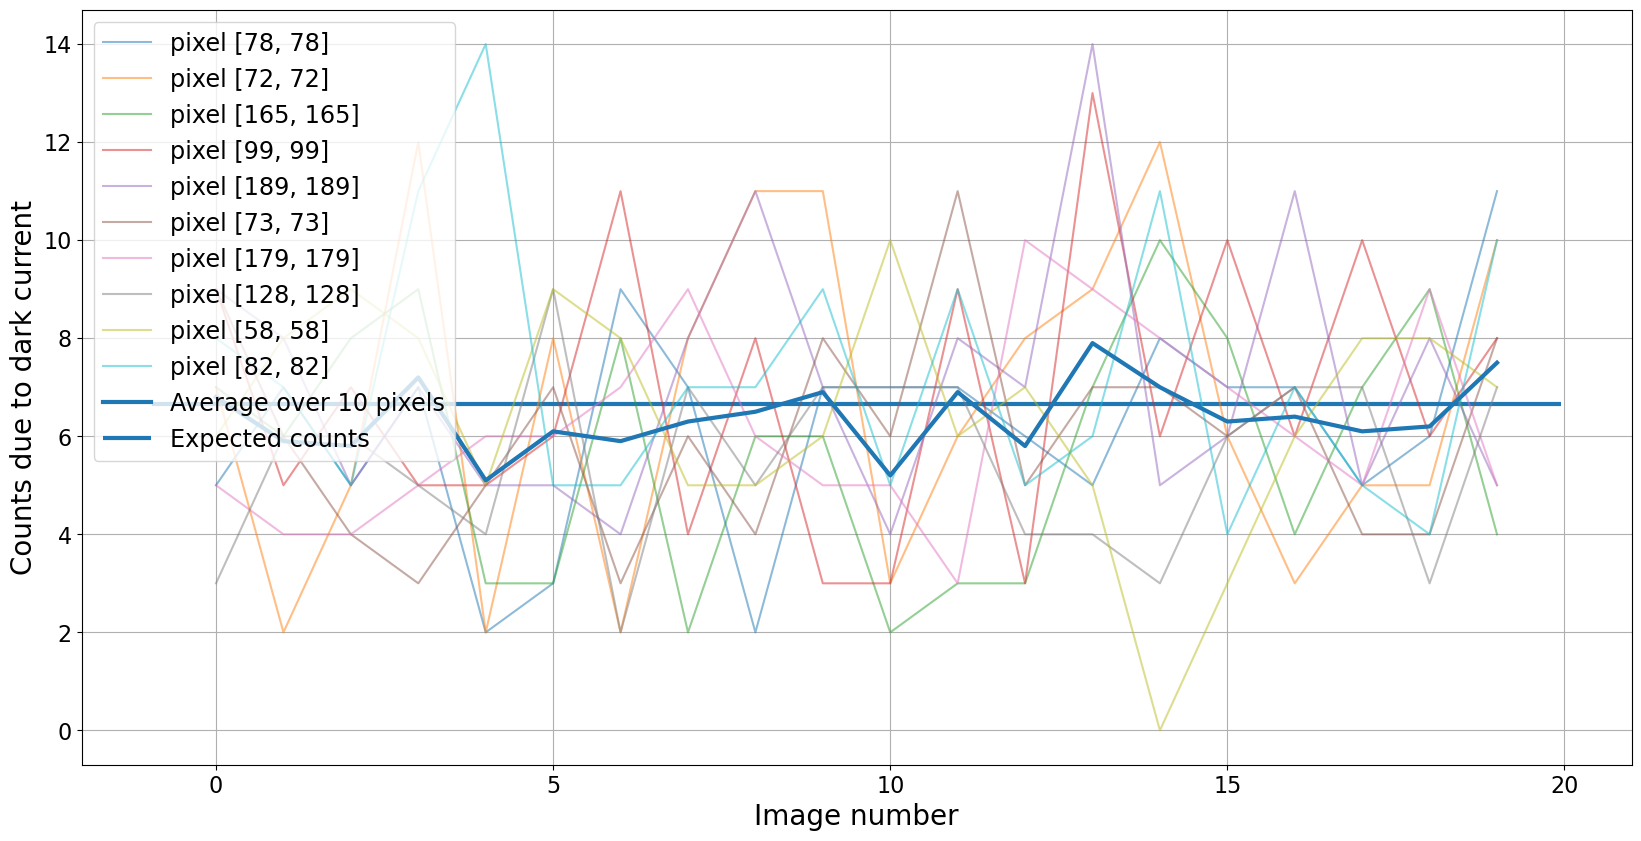

In [11]:
exposure = 100

n_images = 20
n_pixels = 10
image_size = 500



plt.figure(figsize=(20, 10))

darks = generate_dark_frames(n_images, dark_rate=dark_rate, noise=read_noise_electrons,
                             gain=gain, exposure=100, image_size=image_size)


# Pick several random pixels to plot
pixels = np.random.randint(50, high=190, size=n_pixels)
pixel_values = np.zeros(n_images)
pixel_averages = np.zeros(n_images)

for pixel in pixels:
    for n in range(n_images):
        pixel_values[n] = darks[n, pixel, pixel]
    plt.plot(pixel_values, label='pixel [{0}, {0}]'.format(pixel), alpha=0.5)
    pixel_averages += pixel_values


plt.plot(pixel_averages / n_pixels, 
         linewidth=3,
         label='Average over {} pixels'.format(n_pixels))
# plt.xlim(0, n_images - 1)
plt.hlines(dark_rate * exposure / gain, *plt.xlim(), 
           linewidth=3, 
           label="Expected counts")
plt.xlabel('Image number')
plt.ylabel('Counts due to dark current')

plt.legend()
plt.grid()

siempre Cambiara, por la aleatoridad

<h1>3.1.3.2. Los Dark counts siguen una distribución de Poisson

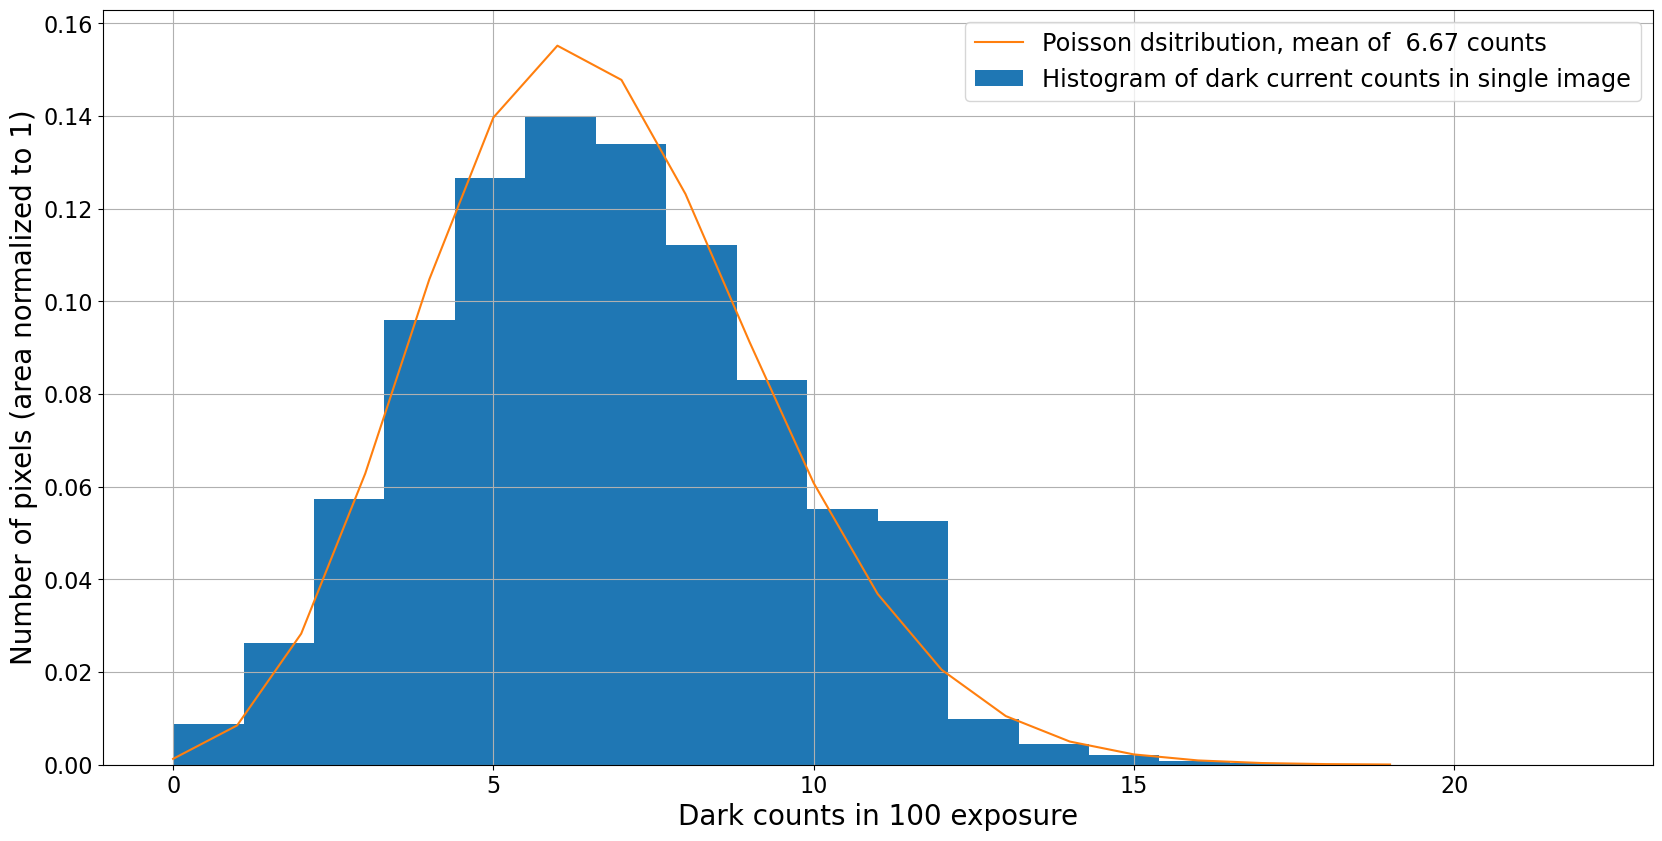

In [12]:
plt.figure(figsize=(20, 10))


h = plt.hist(darks[-1].flatten(), bins=20, align='mid', density=True, 
             label="Histogram of dark current counts in single image");
bins = h[1]
pois = stats.poisson(dark_rate * exposure / gain)
pois_x = np.arange(0, 20, 1)

plt.plot(pois_x, pois.pmf(pois_x), 
         label="Poisson dsitribution, mean of {:5.2f} counts".format(dark_rate * exposure / gain))  

plt.xlabel("Dark counts in {} exposure".format(exposure))
plt.ylabel("Number of pixels (area normalized to 1)")
plt.legend()
plt.grid()

<h1>3.1.4. Ilustración con Dark current y ruido de lectura

Ahora repasemos el mismo par de gráficos con un ruido de lectura distinto de cero. Por el bien de la ilustración, veremos dos casos:

Ruido de lectura moderado de 10  por lectura, típico de un CCD de grado de investigación de gama baja

Bajo ruido de lectura de 1  por lectura

En ambos casos continuaremos con los parámetros anteriores para generar nuestros marcos:

La corriente oscura es /píxel/seg

La ganancia es /ADU

Tiempo de exposición 100 seg

Con esas opciones, el conteo oscuro esperado es 6.67, que es 10 . Ese es, no por casualidad, uno de los valores para el ruido de lectura que se eligió.

La tasa de corriente oscura en este ejemplo es algo más alta que la de un CCD real. Aquí se usa una gran corriente oscura para demostrar la interacción de la corriente oscura y el ruido de lectura, y se ha elegido el tiempo de exposición para que los electrones oscuros esperados sean 10.

<h1>3.1.4.1. Alto ruido

In [13]:
high_read_noise = 10

In [14]:
darks = generate_dark_frames(n_images, dark_rate=dark_rate, noise=high_read_noise, 
                             gain=gain, exposure=exposure, image_size=image_size)

image_average = darks.mean(axis=0)

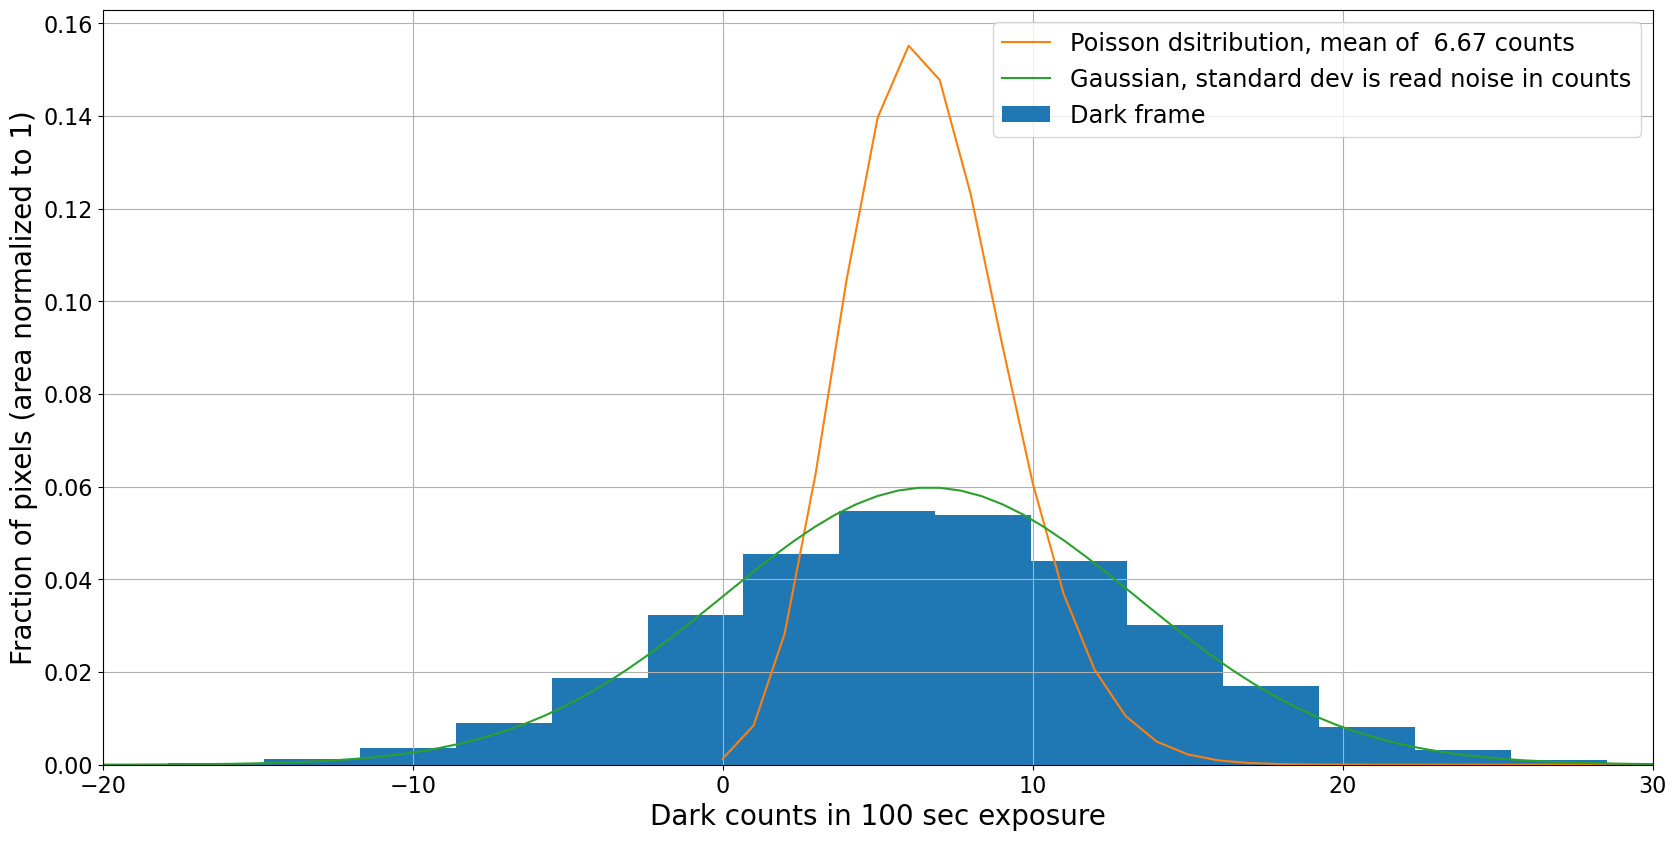

In [15]:
plt.figure(figsize=(20, 10))

plot_dark_with_distributions(darks[-1], high_read_noise, dark_rate, 
                             n_images=1, exposure=exposure, gain=gain)

plt.xlim(-20, 30);

#### Este marco oscuro mide el ruido, no la corriente oscura

La distribución de píxeles es claramente una distribución gaussiana con un ancho determinado por el ruido de lectura, no la distribución de Poisson subyacente que un marco oscuro intenta medir. La única forma de evitar esto (suponiendo que la corriente oscura sea lo suficientemente grande como para que sea necesario restarla) es hacer que la exposición sea lo suficientemente larga para que los recuentos esperados excedan la corriente oscura.

Exploramos ese caso a continuación agregando una cantidad mucho menor de ruido.

#### Combinar no recupera la corriente oscura

Los gráficos a continuación muestran el resultado de promediar varios (20 en este caso) marcos oscuros juntos. Podríamos esperar que el promedio reduzca el ruido lo suficiente como para que la distribución de píxeles se convierta en la distribución de Poisson esperada para un cuadro oscuro. No es asi.

Nota: Para calcular correctamente la distribución esperada de conteos en el promedio de los cuadros oscuros, debe comenzar con las expectativas de la suma de las imágenes, luego escalar los conteos hacia abajo por el número de imágenes y la distribución hacia arriba por el mismo factor para que el la distribución permanece normalizada.

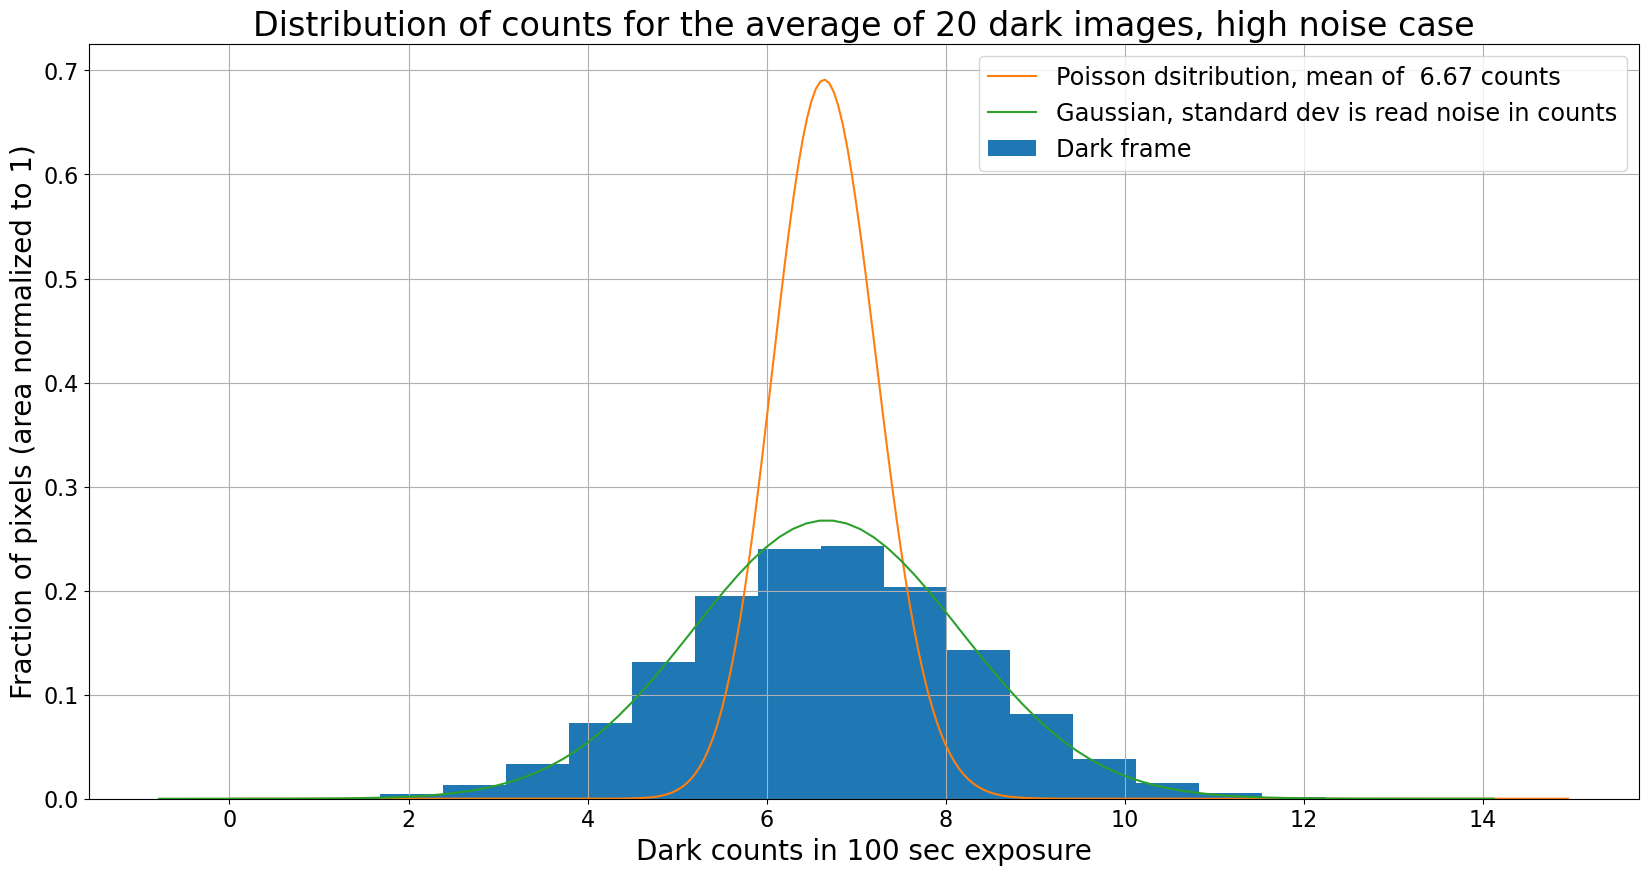

In [16]:
plt.figure(figsize=(20, 10))

plot_dark_with_distributions(image_average, high_read_noise, dark_rate, 
                             n_images=20, exposure=exposure, gain=gain)

plt.title("Distribution of counts for the average of 20 dark images, high noise case");

<h1>3.1.4.2. Bajo nivel de ruido

In [17]:
low_read_noise = 1

darks = generate_dark_frames(n_images, dark_rate=dark_rate, noise=low_read_noise, 
                             gain=gain, exposure=exposure, image_size=image_size)

image_average = darks.mean(axis=0)

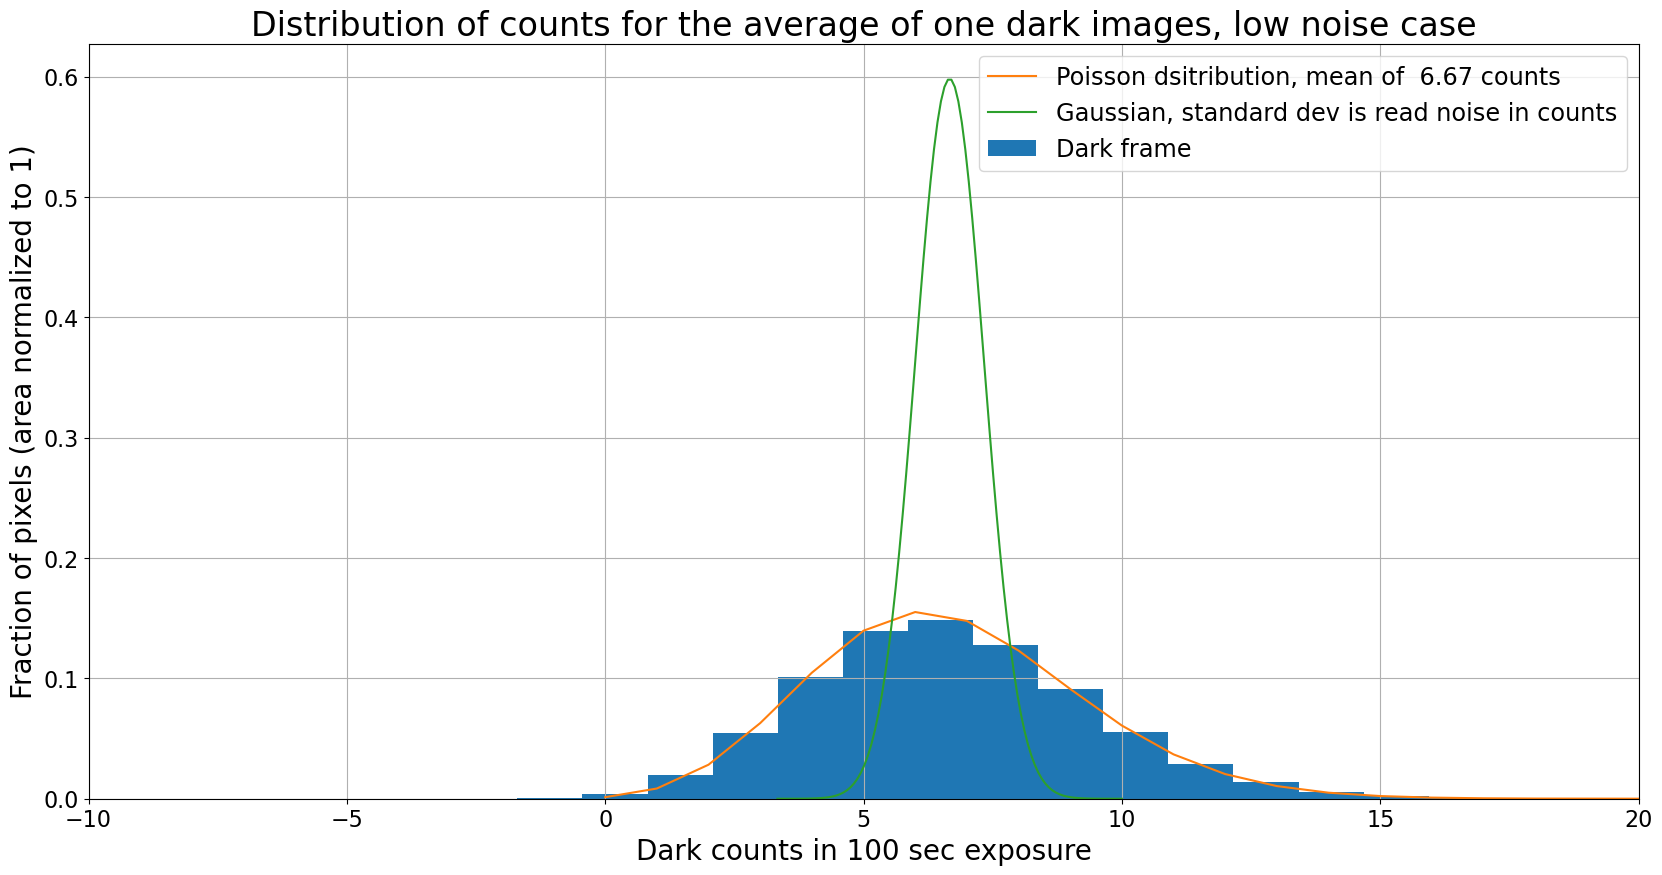

In [18]:
plt.figure(figsize=(20, 10))


plot_dark_with_distributions(darks[-1], low_read_noise, dark_rate, 
                             n_images=1, exposure=exposure, gain=gain)

#plt.ylim(0, 0.8)
plt.xlim(-10, 20)
plt.title("Distribution of counts for the average of one dark images, low noise case");

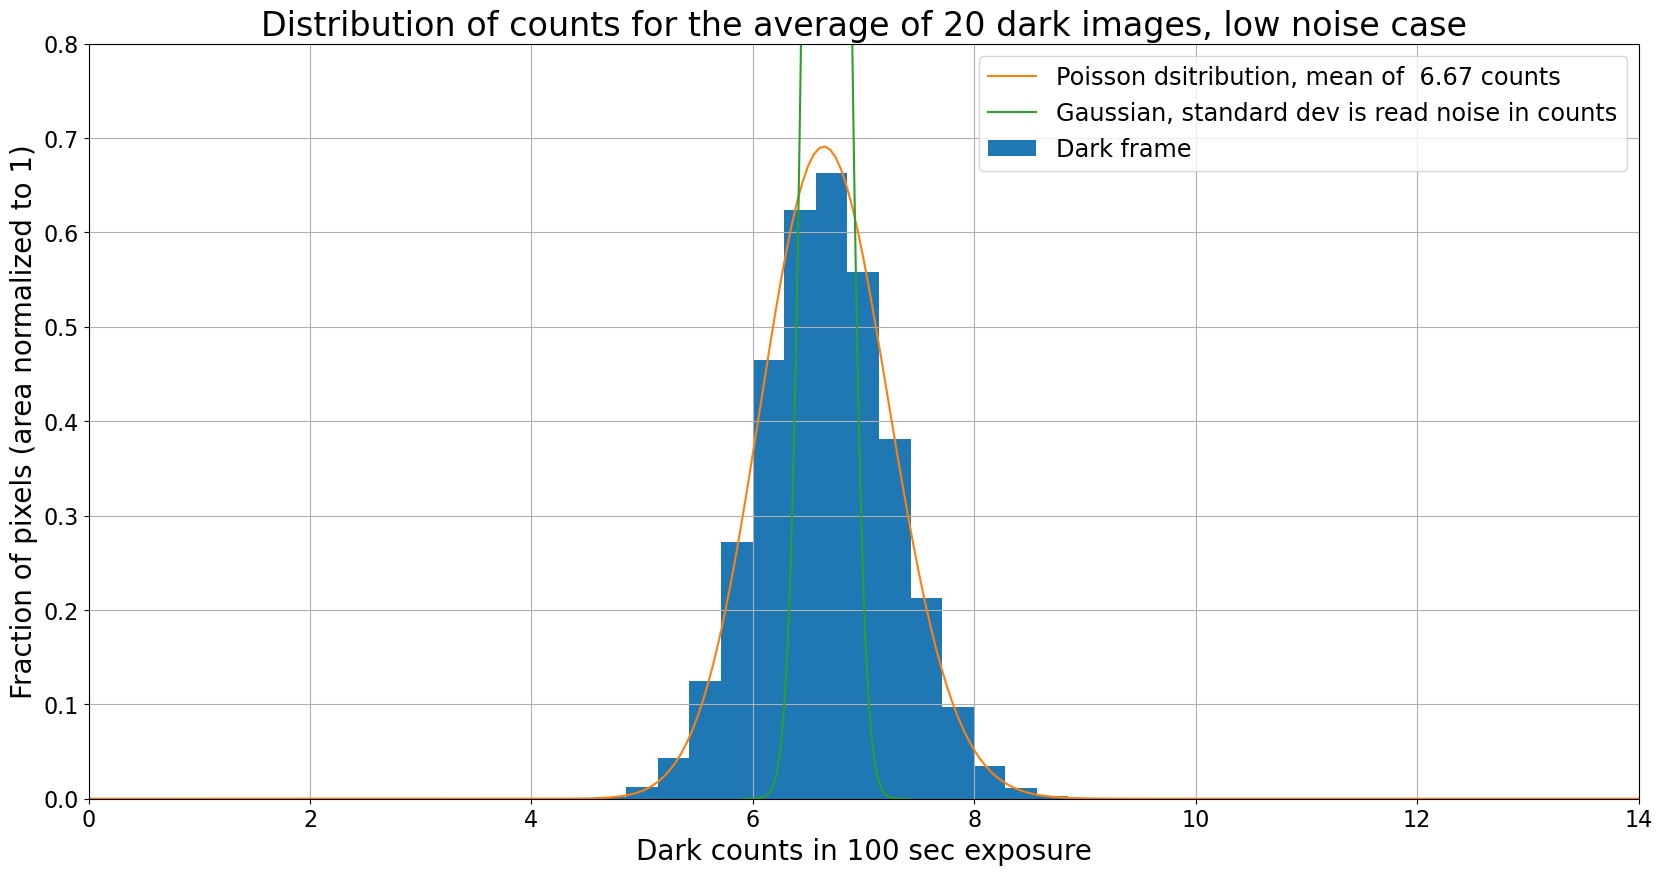

In [19]:
plt.figure(figsize=(20, 10))


plot_dark_with_distributions(image_average, low_read_noise, dark_rate, 
                             n_images=20, exposure=exposure, gain=gain)

plt.ylim(0, 0.8)
plt.xlim(0, 14)
plt.title("Distribution of counts for the average of 20 dark images, low noise case");

### El marco oscuro mide la corriente oscura

A diferencia del caso de alto ruido, los píxeles en un solo marco oscuro de bajo ruido siguen la distribución de Poisson esperada para la corriente oscura en esta cámara simulada. Cuando se combinan varias imágenes, los píxeles aún siguen la distribución de Poisson, como se esperaba en este caso.